### Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.stats import multivariate_normal

# Add the parent directory of simpleparameterisation to the sys.path list
sys.path.append('../')

# Now you can import simpleparameterisation from the new location
import TPCevt as TPC

det = TPC.Detector("Simple TPC with Atmospheric Ar (default values)")


In [2]:
# Initial Parameter
pitch_x = 0.1
pitch_y = 0.1
pitch_z = 0.1
std = det.PSFstd = 1
thresh = 1e-20
chart_scaling = 200

In [3]:
# Function Definition
def getDistribution(grid_size, offset):
    x, y, z = np.mgrid[-grid_size*pitch_x:(grid_size+1)*pitch_x:pitch_x,
            -grid_size*pitch_y:(grid_size+1)*pitch_y:pitch_y,
            -grid_size*pitch_z:(grid_size+1)*pitch_z:pitch_z,
            ]
    offset_x, offset_y, offset_z = offset

    # gain = np.random.exponential(scale=det.gain_mean)
    gain = 1
    # top_right = np.stack((np.array([x+pitch_x/2-offset_x, y+pitch_y/2-offset_y])), axis=-1)
    # bottom = np.stack((np.array([x+pitch_x/2-offset_x, y-pitch_y/2-offset_y])), axis=-1)
    # left = np.stack((np.array([x-pitch_x/2-offset_x, y+pitch_y/2-offset_y])), axis=-1)
    # bottom_left = np.stack((np.array([x-pitch_x/2-offset_x, y-pitch_y/2-offset_y])), axis=-1)
    val = rv.pdf(np.stack((x, y, z), axis = -1))*pitch_x*pitch_y*pitch_z*gain
    # gain=1 #not considering gain effect for temporary

    # val = (rv.cdf(top_right) - rv.cdf(bottom) - rv.cdf(left) + rv.cdf(bottom_left))*gain

    # plt.figure()
    # plt.title('Val CDF')
    # plt.scatter(x, y, c=val_cdf)
    # plt.xlim(-5, 5)
    # plt.ylim(-5, 5)
    # plt.colorbar()
    return x, y, z, val

def applyThreshold(x_1, y_1, z_1, readout_1, thresh):
    mask_1 = readout_1 >= thresh
    x_1_filtered = x_1[mask_1].flatten()
    y_1_filtered = y_1[mask_1].flatten()
    z_1_filtered = z_1[mask_1].flatten()
    
    readout_1_filtered = readout_1[mask_1]
    return x_1_filtered, y_1_filtered, z_1_filtered, readout_1_filtered



def filterCoord(x, y, z, val, minvals, maxvals):
    # Convert input lists to NumPy arrays
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    val = np.array(val)

    # Define masks for filtering
    x_mask = (minvals[0] <= x) & (x <= maxvals[0])
    y_mask = (minvals[1] <= y) & (y <= maxvals[1])
    z_mask = (minvals[2] <= z) & (z <= maxvals[2])

    # Combine the masks to get the final filtering mask
    final_mask = x_mask & y_mask & z_mask

    # Use the filtering mask to get the filtered arrays
    filtered_x = x[final_mask]
    filtered_y = y[final_mask]
    filtered_z = z[final_mask]
    filtered_val = val[final_mask]

    return [filtered_x, filtered_y, filtered_z, filtered_val]


def filterCoord_vect(x, y, z, val, minvals, maxvals):
    # Convert input lists to NumPy arrays
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    val = np.array(val)

    # Define masks for filtering
    x_mask = (minvals[0] <= x) & (x <= maxvals[0])
    y_mask = (minvals[1] <= y) & (y <= maxvals[1])
    z_mask = (minvals[2] <= z) & (z <= maxvals[2])

    # Combine the masks to get the final filtering mask
    final_mask = x_mask & y_mask & z_mask

    # Use the filtering mask to get the filtered arrays
    filtered_x = x[final_mask]
    filtered_y = y[final_mask]
    filtered_z = z[final_mask]
    filtered_val = val[final_mask]

    return [filtered_x, filtered_y, filtered_z, filtered_val]


def getGridProps(coord, delta):
    index = int((coord + delta / 2) // delta)
    offset = coord - index*delta
    return index, offset

def count_decimal_places(number):
    if "." not in str(number):
        return 0
    return len(str(number).split(".")[1])

def generate_random_coordinates(N):
    # Generate random [x, y, z] coordinates
    x = np.random.rand(N)
    y = np.random.rand(N)
    z = np.random.rand(N)

    # Combine x, y, z coordinates into a single array
    coordinates = np.column_stack((x, y, z))

    return coordinates


def ReadoutGain(DriftedEvt):
    DriftedEvtGrid = np.stack(DriftedEvt, axis=-1)
    minvals = np.array([DriftedEvtGrid[0].min(), DriftedEvtGrid[1].min(), DriftedEvtGrid[2].min()])
    maxvals = np.array([DriftedEvtGrid[0].max(), DriftedEvtGrid[1].max(), DriftedEvtGrid[2].max()])
    print(minvals, maxvals)
    CombinedEvt = {}
    comma_num_x = count_decimal_places(pitch_x)
    comma_num_y = count_decimal_places(pitch_y)
    comma_num_z = count_decimal_places(pitch_z)

    def combineData(x, y, z, val):
        for i in range(len(x)):
            key = (np.around(x[i], comma_num_x), np.around(y[i], comma_num_y), np.around(z[i], comma_num_z))
            if key in CombinedEvt:
                # print('initial', CombinedEvt[key])
                CombinedEvt[key] += val[i]
                # print('final', CombinedEvt[key])
            else:
                CombinedEvt[key] = val[i]

    for i in range(len(DriftedEvt)):
        coord = DriftedEvt[i]
        (index_x, offset_x) = getGridProps(coord[0], pitch_x)
        # print('index_x: ', index_x,', offset_x: ',  offset_x)

        (index_y, offset_y) = getGridProps(coord[1], pitch_y)
        # print('index_y: ', index_y,', offset_y: ',  offset_y)

        (index_z, offset_z) = getGridProps(coord[2], pitch_z)
        # print('index_y: ', index_y,', offset_y: ',  offset_y)

        x_1, y_1, z_1, readout_1 = getDistribution(grid_size, [offset_x, offset_y, offset_z])

        x_1_filtered, y_1_filtered, z_1_filtered, readout_1_filtered = applyThreshold(x_1, y_1, z_1, readout_1, thresh)
        
        x_1_filtered += index_x*pitch_x
        y_1_filtered += index_y*pitch_y
        z_1_filtered += index_z*pitch_z
        
        # plt.figure()
        # plt.title('DriftedEvt item-')
        # plt.scatter(x_1_filtered, y_1_filtered, c=readout_1_filtered)
        # plt.colorbar()
        
        combineData(x_1_filtered, y_1_filtered, z_1_filtered, readout_1_filtered)
        x_comb, y_comb, z_comb = zip(*CombinedEvt.keys())
        
    val_comb = list(CombinedEvt.values())
    # print('time vectorization')
    # %timeit filtered_coord_vect = filterCoord_vect(x_comb, y_comb, z_comb, val_comb, minvals, maxvals)
    # print('time loop')
    # %timeit filtered_coord = filterCoord(x_comb, y_comb, z_comb, val_comb, minvals, maxvals)
    
    filtered_coord = filterCoord(x_comb, y_comb, z_comb, val_comb, minvals, maxvals)
    
    return pd.DataFrame({'x': filtered_coord[0],
                                    'y':filtered_coord[1],
                                    'z':filtered_coord[2],
                                    'Nel': filtered_coord[3]
                                    })

def plotReadout(ReadoutEvt, a, b):
    plt.figure(1)
    projectxy = pd.DataFrame(ReadoutEvt.groupby(['x','y'])['Nel'].sum()).reset_index()
    plt.scatter(projectxy.x,projectxy.y, c=projectxy.Nel, s=((projectxy.Nel/np.max(projectxy.Nel))**0.5)*chart_scaling)
    plt.colorbar()
    plt.xlim(a, b)
    plt.ylim(a, b)
    plt.title(" X-Y Chart ")

    plt.figure(2)
    projectxdt = pd.DataFrame(ReadoutEvt.groupby(['x','z'])['Nel'].sum()).reset_index()
    plt.scatter(projectxdt.x,projectxdt.z, c=projectxdt.Nel, s=((projectxdt.Nel/np.max(projectxdt.Nel))**0.5)*chart_scaling)
    plt.colorbar()
    plt.xlim(a, b)
    plt.ylim(a, b)
    plt.title(" X-Z Chart ")

    plt.figure(3)
    projectydt = pd.DataFrame(ReadoutEvt.groupby(['y','z'])['Nel'].sum()).reset_index()
    plt.scatter(projectydt.y,projectydt.z, c=projectydt.Nel, s=((projectydt.Nel/np.max(projectydt.Nel))**0.5)*chart_scaling)
    plt.colorbar()
    plt.xlim(a, b)
    plt.ylim(a, b)
    plt.title(" Y-Z Chart ")
    
    fig = plt.figure(4)
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    scatter = ax.scatter(ReadoutEvt['x'], ReadoutEvt['y'], ReadoutEvt['z'], c=ReadoutEvt['Nel'], cmap='viridis', marker='o')
    cbar = plt.colorbar(scatter)
    plt.title(" X-Y-Z Chart")
    plt.show()

### Benchmark 1

In [4]:
pitch_x = 1
pitch_y = 1
pitch_z = 1
std = det.PSFstd = 1
thresh = 1e-20
grid_size = 100
rv = multivariate_normal([0,0,0], np.diag([std, std, std]))

DriftedEvt = np.array([[1,1,1], [5,5,5], [10,10,10]])
ReadoutEvt = ReadoutGain(DriftedEvt)

[1 1 1] [10 10 10]


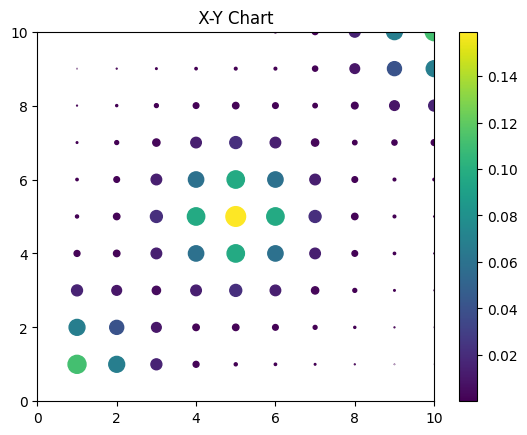

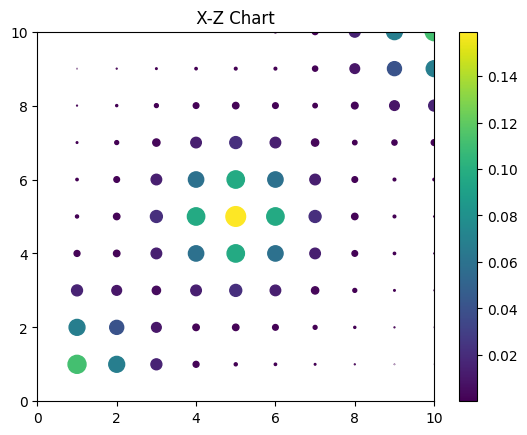

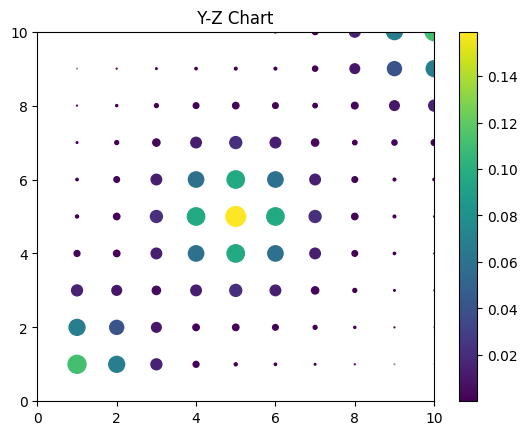

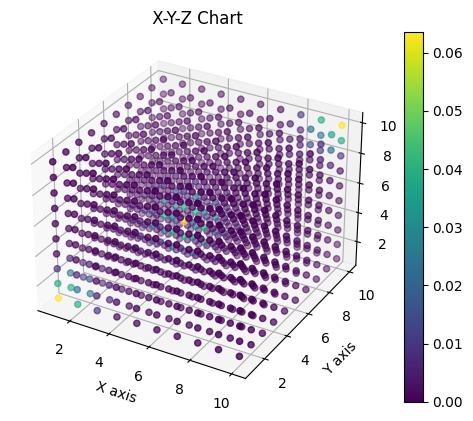

In [5]:
plotReadout(ReadoutEvt, 0, 10)

### Benchmark 2

In [6]:
pitch_x = 1
pitch_y = 1
pitch_z = 1
std = det.PSFstd = 1
thresh = 1e-20
grid_size = 100
rv = multivariate_normal([0,0,0], np.diag([std, std, std]))

DriftedEvt = np.array([[1,1,1], [5000, 5000, 5000], [10000, 10000, 10000]])
ReadoutEvt = ReadoutGain(DriftedEvt)

[1 1 1] [10000 10000 10000]


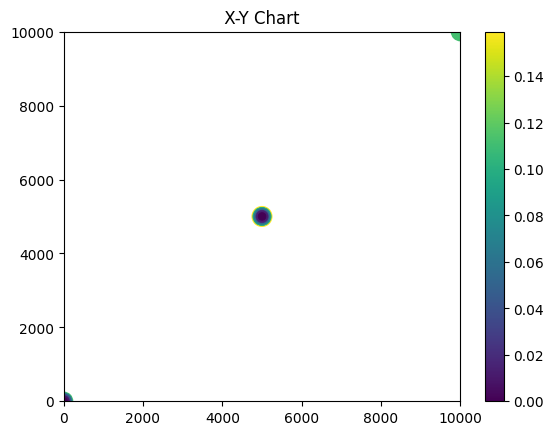

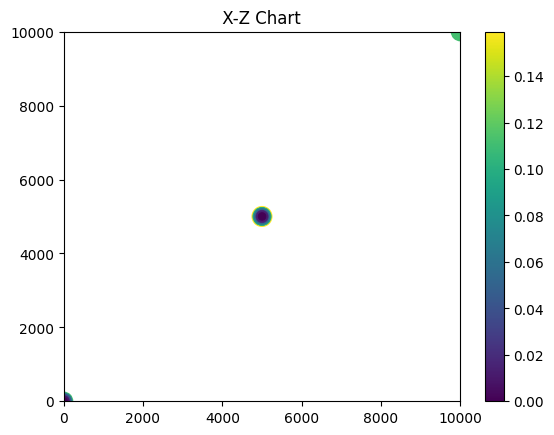

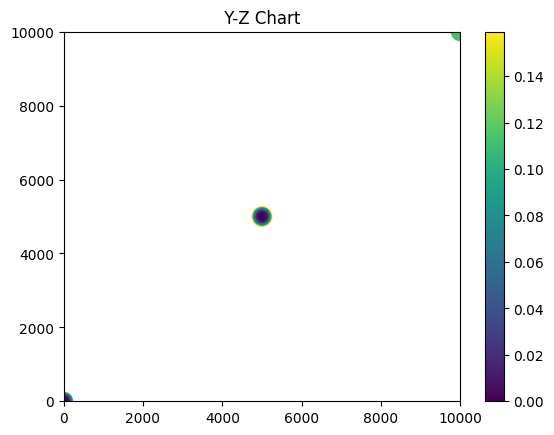

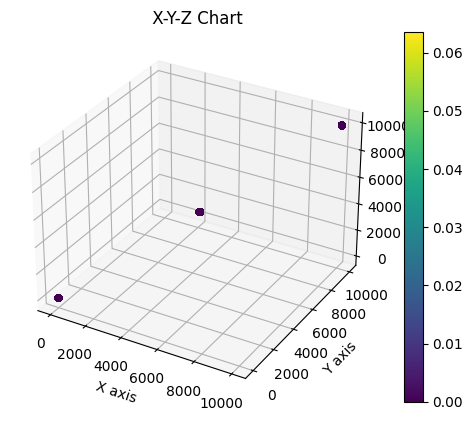

In [7]:
plotReadout(ReadoutEvt, 0, 10000)

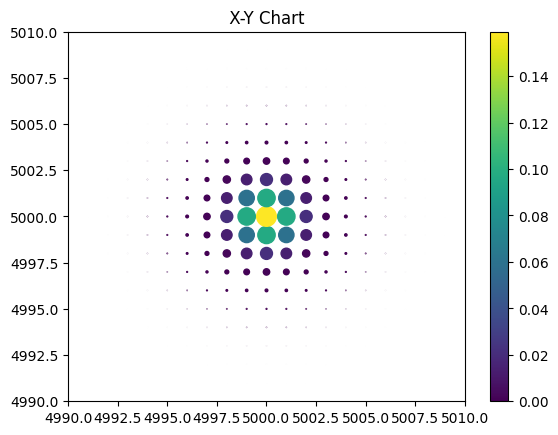

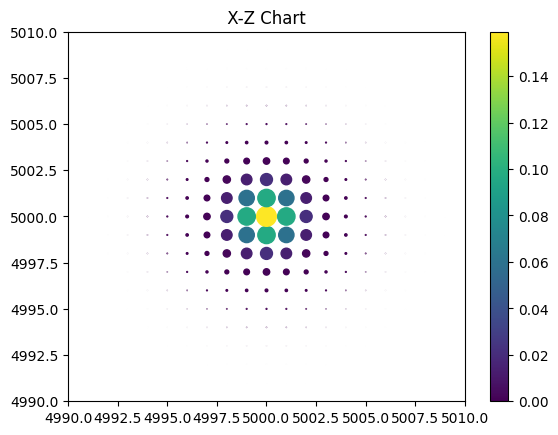

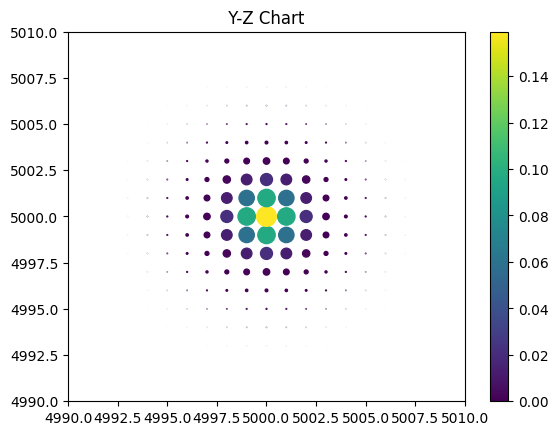

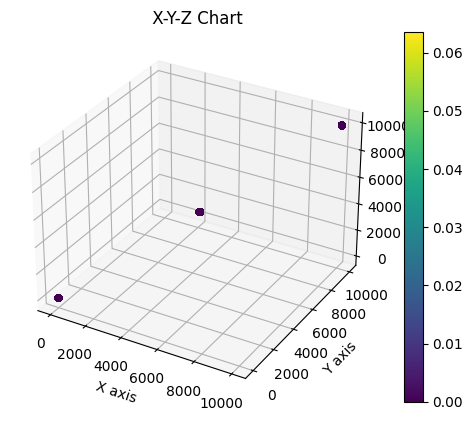

In [8]:
plotReadout(ReadoutEvt, 4990, 5010)

### Benchmark 3

In [9]:
N = 100  # Replace 10 with the desired length
k = 100

DriftedEvt = generate_random_coordinates(N)*k

print(DriftedEvt)


[[81.01418493  4.59568744 53.72605517]
 [72.27820802 17.73976932 75.9994236 ]
 [16.42084208 69.0876512   3.54932134]
 [54.9996434  43.70305897 44.64660342]
 [58.68141631 15.45499027 28.11064629]
 [13.84774397 74.96733569 32.69494604]
 [92.12487473 15.20351534 60.78757119]
 [54.79443579 87.73072004 61.57619558]
 [23.98625875 58.27988702 50.11323221]
 [26.59898544 10.16367214  6.3376999 ]
 [41.72309202 68.82845355 23.1510358 ]
 [17.23957697 95.81562759 33.0859448 ]
 [85.07989127  6.02266554 36.33011027]
 [42.19152236 77.00424786 89.09715679]
 [24.9677528  88.42995102 11.61637147]
 [64.13701674 96.23921214 72.99772854]
 [11.40836964 24.34220223 20.13745689]
 [ 3.84893245 68.33261065 11.00005477]
 [44.93151746 39.09384154 97.63234998]
 [83.16266603 86.22506947 54.84671625]
 [66.42801634 32.98797086 41.47441494]
 [34.85572797 52.56874668 85.48617994]
 [82.25828028 49.72990541 38.2181029 ]
 [33.34525057 90.18669308 82.97005051]
 [19.84012281 96.89962892 39.98632441]
 [14.12425458  4.18394638

In [10]:
pitch_x = 1
pitch_y = 1
pitch_z = 1
std = det.PSFstd = 1
thresh = 1e-20
grid_size = 100
rv = multivariate_normal([0,0,0], np.diag([std, std, std]))

ReadoutEvt = ReadoutGain(DriftedEvt)

[0.55328781 1.98431411 2.59448502] [96.32525507 99.49412987 98.84067815]


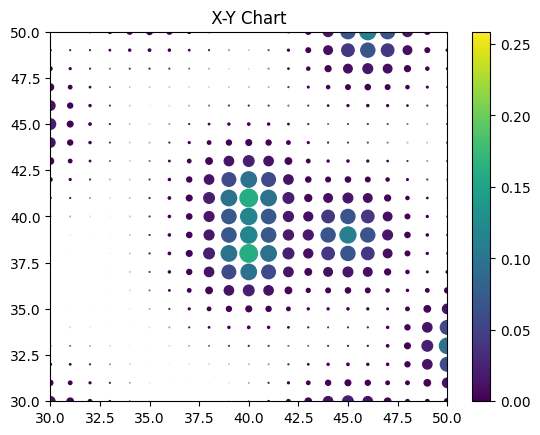

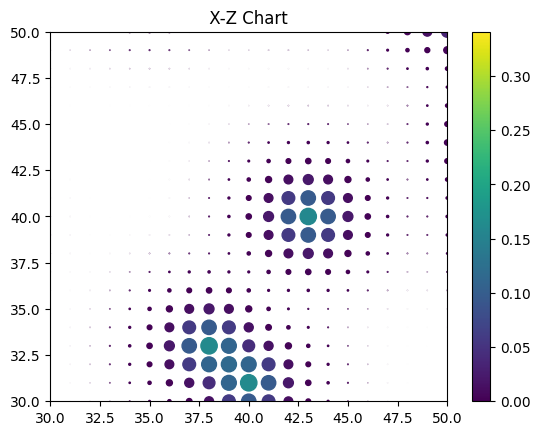

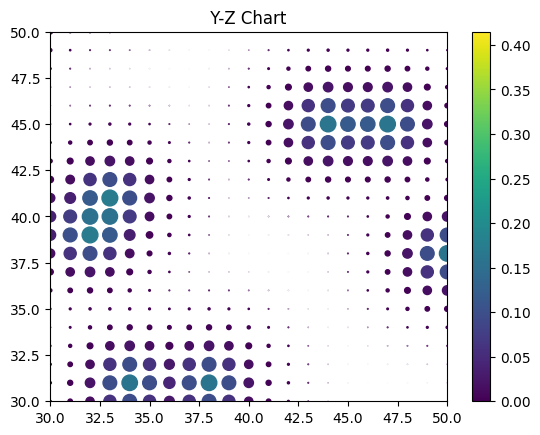

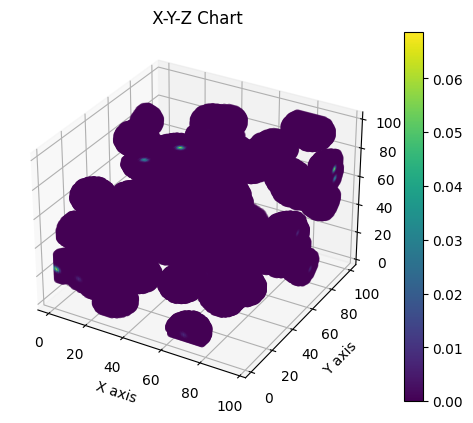

In [11]:
plotReadout(ReadoutEvt, 30, 50)